In [161]:
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('../src/construct/')
import util

ch_end_use = '../data/automatic/ch_hh_end_use.xlsx'

CH_HH_END_USE_TRANSLATION = {
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating',
    'Prozesswärme': 'process_heating',
    'Beleuchtung': 'end_use_electricity',
    'Klima, Lüftung, HT': 'space_cooling',
    'I&K, Unterhaltung': 'end_use_electricity',
    'Antriebe, Prozesse': 'end_use_electricity',
    'sonstige': 'other'
}

CH_ENERGY_CARRIER_TRANSLATION = {
    'Heizöl': 'fuel',
    'Erdgas': 'fuel',
    'El. Widerstandsheizungen': 'electricity',
    'El. Wärmepumpen 1)': 'electricity',
    "El. Ohm'sche Anlagen": 'electricity',
    'El. Wärmepumpen': 'electricity',
    'Elektrizität': 'electricity',
    'Holz': 'fuel',
    'Kohle': 'fuel',
    'Fernwärme': 'fuel',
    #'Umweltwärme': 'ambient_heat',
    'Solar': 'fuel',
}

uk_cat_name = {
    'Domestic': 'domestic', 
    'Industry': 'industry', 
    'Services (excl agriculture)': 'commercial'
}
uk_end_uses = {
    'Cooking/catering': 'cooking', 
    'Space heating': 'space_heating', 
    'Water heating': 'water_heating', 
    'High temperature process': 'process_heating', 
    'Low temperature process': 'process_heating', 
    'Drying/separation': 'process_heating', 
    'Overall total': 'total'   
}
uk_carriers = {
    'Bioenergy & Waste': 'biofuel', 
    'Electricity': 'electricity', 
    'Gas': 'gas', 
    'Heat sold': 'heat', 
    'Oil': 'oil',
    'Solid fuel': 'solid_fossil'
}

at_end_uses = {
    'electrochemial_purposes': 'end_use_electricity',
    'industrial_\nfurnaces': 'process_heating',
    'lighting_and_computing': 'end_use_electricity',
    'space_heating_and_air_condition': 'space_heating_cooling',
    'stationary_\nengines': 'end_use_electricity',  # backup generators?
    #'traction': 'transport',
    'vapor_\nproduction': 'process_heating',
}
at_carriers = {
    'Ambient and solar heat': 'renewable_heat',
    'Biofuels': 'biofuel',
    'Blast furnace gas': 'gas',
    'Coke oven coke': 'solid_fossil',
    'Coke oven gas': 'solid_fossil',
    'Diesel': 'oil',
    'District heat': 'heat',
    'Electricity': 'electricity',
    'Fuel oil': 'oil',
    'Fuel wood': 'biofuel',
    'Gas oil': 'oil',
    'Gasoline': 'oil',
    'Hard coal': 'solid_fossil',
    'Kerosene': 'oil',
    'LPG': 'oil',
    'Lignite': 'solid_fossil',
    'Natural gas': 'gas',
    'Other energy sources': 'other',
    'Peat': 'solid_fossil',
    'Petrol coke': 'solid_fossil',
    'Waste': 'waste'
}
idx = pd.IndexSlice

# Switzerland

In [3]:
def get_ch_sheet(path_to_excel, sheet, skipfooter, translation=None):
    _df = (
        pd.read_excel(
            path_to_excel, sheet_name=sheet,
            skiprows=9, skipfooter=skipfooter, index_col=1
        )
        .drop(['Unnamed: 0', 'Δ ’00 – ’18'], axis=1)
    )
    _df.index = _df.index.str.strip()
    _df.columns = _df.columns.astype(int)

    if translation is not None:
        return _df.groupby(translation).sum()
    else:
        return _df

In [4]:
dfs = []
for k, v in {
    'Tabelle 25': ('commercial', 'fuel'), 
    'Tabelle26': ('commercial', 'electricity'), 
    'Tabelle 29': ('industry', 'fuel'), 
    'Tabelle30': ('industry', 'electricity')
}.items():
    _df = (
        get_ch_sheet(ch_end_use, k, skipfooter=4, translation=CH_HH_END_USE_TRANSLATION)
        .apply(util.pj_to_twh)
        .assign(carrier_name=v[1], cat_name=v[0])
        .set_index(['carrier_name', 'cat_name'], append=True)
        .stack()
        .rename_axis(index=['end_use', 'carrier_name', 'cat_name', 'year'])
        .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year'])
    )
    dfs.append(_df)
ch_end_use_df = pd.concat(dfs)

In [5]:
ch_hh_end_use_df_sh = get_ch_sheet(
    ch_end_use, 'Tabelle 18', skipfooter=8, translation=CH_ENERGY_CARRIER_TRANSLATION
)
ch_hh_end_use_df_hw = get_ch_sheet(
    ch_end_use, 'Tabelle 20', skipfooter=5, translation=CH_ENERGY_CARRIER_TRANSLATION
)
# Quirk of the excel is that there is no space in this sheet name
ch_hh_end_use_df_c = get_ch_sheet(
    ch_end_use, 'Tabelle21', skipfooter=4, translation=CH_ENERGY_CARRIER_TRANSLATION
)

ch_hh_end_use_df = (
    pd.concat(
        [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c],
        keys=('space_heating', 'water_heating', 'cooking'),
        names=['end_use', 'carrier_name']
    )
    .apply(util.pj_to_twh)
    .assign(cat_name='domestic')
    .set_index('cat_name', append=True)
)

ch_hh_end_use_df.columns = ch_hh_end_use_df.columns.astype(int).rename('year')

ch_end_use_df = ch_end_use_df.append(ch_hh_end_use_df.stack().reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year']))

# UK

In [116]:
sheet = pd.read_excel(
    'https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/820752/2019_End_use_tables.xlsx', 
    sheet_name='Table U2', skiprows=4
)
dfs = []
table_ends = sheet[sheet['End use'] == 'Overall total excluding transport'].index
table_ends = table_ends.insert(0, -1)
for i in range(0, len(table_ends) - 1):
    _df = sheet.iloc[table_ends[i] + 1:table_ends[i + 1] + 1].dropna(how='all').dropna(how='all', axis=1)

    year = _df.iloc[0, 2]
    _df = _df.iloc[1:]
    _df['Sector'] = _df.Sector.ffill()
    _df = (
        _df
        .groupby(['Sector', 'End use']).sum()
        .stack()
        .groupby([uk_cat_name, uk_end_uses, uk_carriers], level=[0, 1, 2]).sum()
        .unstack()
        .apply(util.ktoe_to_twh)
        .assign(year=int(year))
        .set_index('year', append=True)
        .stack()
        .rename_axis(index=['cat_name', 'end_use', 'year', 'carrier_name'])
        .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year'])
    )
    
    
    dfs.append(_df)
uk_end_use_df = pd.concat(dfs)

other = uk_end_use_df.xs('total', level='end_use') - uk_end_use_df.drop('total', level='end_use').sum(level=['cat_name', 'carrier_name', 'year'])
uk_end_use_df = (
    uk_end_use_df.append(
        other
        .unstack()
        .assign(end_use='end_use_electricity')
        .set_index('end_use', append=True)
        .stack()
        .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year'])
    )
    .drop('total', level='end_use')
)

# Austria

In [7]:
# Extract Austrian data
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="K:S", skiprows=30, header=None
            ).dropna(how='all', subset=range(12, 19))
            table_ends = _end_use_demand[_end_use_demand[10] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(10).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop('Total', axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [99]:
at_df = get_at_end_use_df(region='AT')

In [162]:
at_end_use_df = (
    at_df
    .xs('Commercial and public services', level=1)
    .stack()
    .unstack('year')
    .groupby([at_carriers, at_end_uses], level=[0, -1]).sum(min_count=1)
    .where(lambda x: x > 0)
    .dropna(how='all')
    .apply(util.tj_to_twh)
    .rename_axis(index=['carrier_name', 'end_use'], columns='year')
    .stack()
)

# JRC IDEES

In [134]:
jrc_end_use_df = pd.read_csv('../data/commercial/JRC_IDEES_commercial_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
jrc_end_use_df = jrc_end_use_df.xs('ktoe', level='unit').apply(util.ktoe_to_twh).loc[idx[:, :, ['AT', 'CH', 'UK'], :]]

# Compare

In [163]:
all_countries_df = pd.concat([at_end_use_df, uk_end_use_df.xs('commercial'), ch_end_use_df.xs('commercial')], names=['country_code'], keys=['AT', 'UK', 'CH'])

In [164]:
all_countries_df.to_csv('../data/commercial/published_commerical_end_use_consumption.csv')

(0.0, 1.0, 0.0, 1.0)

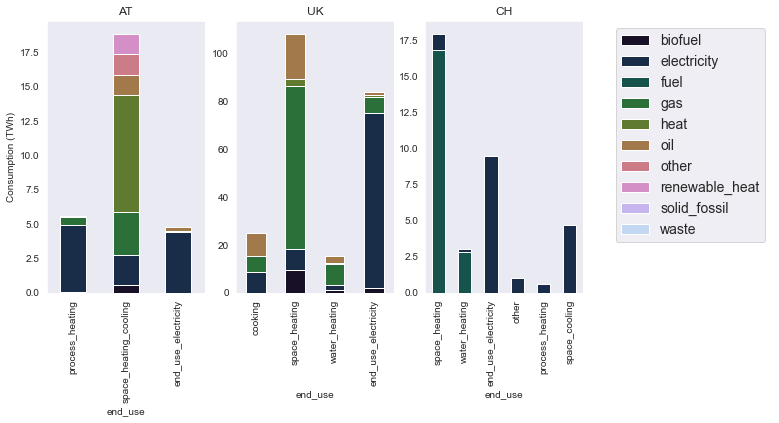

In [165]:
# Plot percentage contribution of different energy carriers to end-use demand in UK sectors
fig, ax = plt.subplots(1, 4, figsize=(13, 5))
colors = {all_countries_df.index.levels[1][i]: sns.color_palette("cubehelix", 11)[i] for i in range(len(all_countries_df.index.levels[1]))}
sns.set_style("dark")
_ax = 0
for country in all_countries_df.index.levels[0]:
    _df = all_countries_df.xs((country, 2017), level=('country_code', 'year')).unstack('carrier_name')
    _df.plot.bar(color=[colors[i] for i in _df.columns], stacked=True, ax=ax[_ax], legend=False)
    ax[_ax].set_title(country.upper())
    if _ax == 0:
        ax[_ax].set_ylabel('Consumption (TWh)')
    _ax += 1

legend = [mpl.patches.Patch(facecolor=v, label=k) for k, v in colors.items()]
ax[_ax].legend(handles=legend, fontsize=14)
ax[_ax].axis('off')

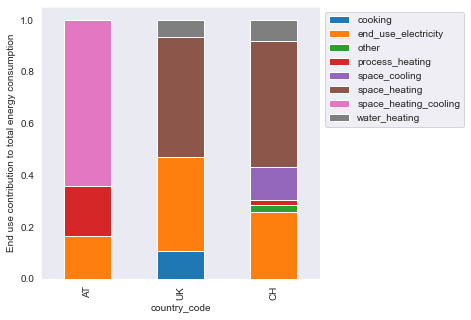

In [166]:
# Plot percentage contribution of different energy carriers to end-use demand in UK sectors
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.set_style("dark")
_df = all_countries_df.xs((2017), level=('year')).sum(level=('end_use', 'country_code'))
_df = _df.div(_df.sum(level='country_code')).unstack('end_use')
_df.plot.bar(stacked=True, ax=ax)
ax.set_ylabel('End use contribution to total energy consumption')
ax.legend(bbox_to_anchor=(1, 1))

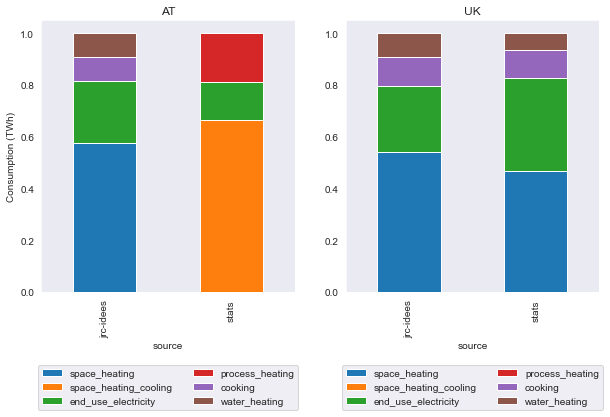

In [180]:
_df = pd.concat([
    all_countries_df.mean(level=('end_use', 'country_code', 'carrier_name')).sum(level=('end_use', 'country_code')).drop('CH', level='country_code'),
    jrc_end_use_df.mean(level=('end_use', 'country_code', 'carrier_name')).sum(level=('end_use', 'country_code'))
], names=['source'], keys=['stats', 'jrc-idees'])
_df = _df.div(_df.sum(level=['source', 'country_code']))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.set_style("dark")
_ax = 0
for country in _df.index.levels[1]:
    _df.unstack('end_use')[['space_heating', 'space_heating_cooling', 'end_use_electricity', 'process_heating', 'cooking', 'water_heating']].xs(country, level='country_code').plot.bar(stacked=True, ax=ax[_ax], legend=True)
    ax[_ax].set_title(country.upper())
    ax[_ax].legend(bbox_to_anchor=(0.5, -0.35), ncol=2, loc='center')
    if _ax == 0:
        ax[_ax].set_ylabel('Consumption (TWh)')
    _ax += 1

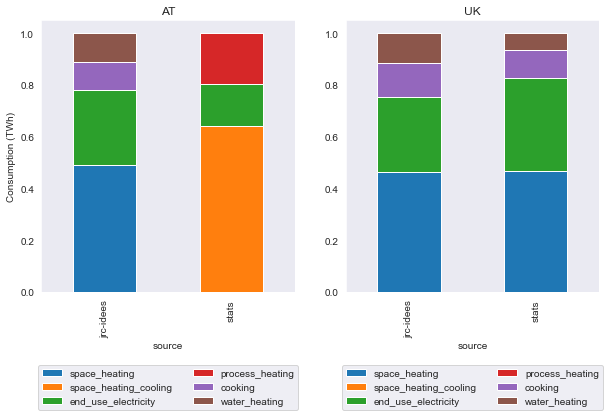

In [184]:
_df = pd.concat([
    all_countries_df.xs(2016, level='year').sum(level=('end_use', 'country_code')).drop('CH', level='country_code'),
    jrc_end_use_df.xs(2015, level='year').sum(level=('end_use', 'country_code'))
], names=['source'], keys=['stats', 'jrc-idees'])
_df = _df.div(_df.sum(level=['source', 'country_code']))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.set_style("dark")
_ax = 0
for country in _df.index.levels[1]:
    _df.unstack('end_use')[['space_heating', 'space_heating_cooling', 'end_use_electricity', 'process_heating', 'cooking', 'water_heating']].xs(country, level='country_code').plot.bar(stacked=True, ax=ax[_ax], legend=True)
    ax[_ax].set_title(country.upper())
    ax[_ax].legend(bbox_to_anchor=(0.5, -0.35), ncol=2, loc='center')
    if _ax == 0:
        ax[_ax].set_ylabel('Consumption (TWh)')
    _ax += 1